# Quantum pattern matching using Grover's algorithm 

#### *Author*: Júlia Barberà, 6th May of 2022

This notebook presents a code to solve a quantum pattern matching problem described as follows: 

We want to find within the string $|w\rangle$, the position where the pattern $|p\rangle$ is located (the index). Using for this example, the string and the pattern below: 

<center> $|w\rangle$ = $|11100000\rangle$ and  $|p\rangle$ = $|10\rangle$, 

we will find that the pattern is located at index 2: $|i\rangle$ = $|2\rangle$.  
    
The algorithm anatomy is presented below: 

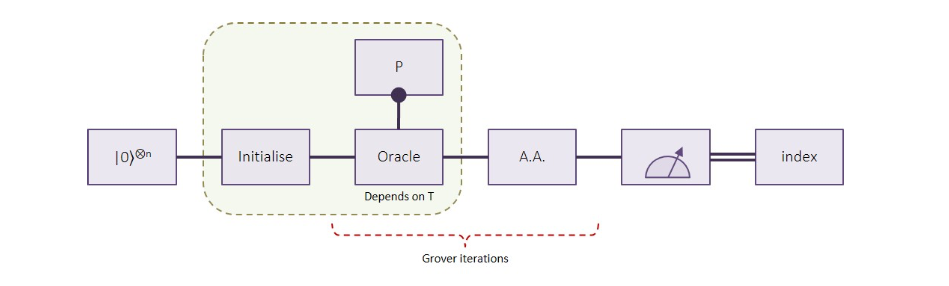

In [250]:
## Import all libraries that I will use
import math as m
import numpy as np
from qibo.models import Circuit
from qibo import gates
from qibo import callbacks
import matplotlib.pyplot as plt

## Functions

Here we define some functions that will be used for solving this pattern matching problem. 

### Decimal to Binary 

This function takes as input the decimal number we need to convert to a binary number.  
First, it uses an integrated python function to convert the number into a binary string and then it removes first two digits "0b".

In [248]:
def bin_list(dec,nqubits): 
    binary = format(dec,'0{}b'.format(nqubits))
    return list(map(int, str(binary)))

There are two methods to convert a binary number into a decimal number and we will use the positional notation to convert them. The weight of the positions will be $2^0, 2^1, 2^2, 2^3,...$ so the first thing we need to do is count the number of digits (positions) the binary number has. Then, these weights will be multiplying the digit corresponding to its binary number (0 or 1). Finally, we will sum up everything. 

Let's assume our binary number is $10110$:


<br>

<center> decimal number $= 1 \cdot 2^4 + 0 \cdot 2^3 + 1 \cdot 2^2 + 1 \cdot 2^1 + 0 \cdot 2^0 = 22 $ </center>


<br>

The binary state will be the one we want to find, and we will use this function to transform the state into a decimal number to find the inverting matrix classically. 

In [249]:
def bin_to_dec(binary_number):
    decimal_number = 0 #Initialize the number 

    for position, string_digit in enumerate(binary_number[::-1]):
        decimal_number += int(string_digit) * 2 ** position

    return decimal_number

### Multi-controlled Z gate 

The CZ gate is used to invert the phase of the state $|11...1\rangle$. To ease the calculation we can express the CZ gate in terms of other quantum logic gates: $Z = H X H$. The gate will be used for the Oracle and the Diffusion operator. 

In [312]:
def MCZ(q0,nqubits): # defining multi-controlled Z function 
    c.add(gates.H(nqubits-1))
    c.add(gates.X(nqubits-1).controlled_by(*range(0,nqubits-1)))
    c.add(gates.H(nqubits-1))
    return c 

### Grover's Oracle: $U_\sigma$

This kind of problem involves as many oracles as letters our alphabet has. In other words, for every different character of the pattern (i.e. 0 and 1 for our case) we need to construct a different oracle. 

Let's consider the case: 
<center> $|w\rangle$ = $|11100000\rangle$ and  $|p\rangle$ = $|10\rangle$. 
    
Our alphabet will be composed by two characters because we are using binary: $\Sigma = \{0,1\}$. We have to see where this pattern is. It can be done following the next steps:
    

1. Take the first character of the pattern: $\sigma = 1 $, to see if there is a match with the rest of characters of the string $|w\rangle$. 
    
2. Compare $\sigma$ with the rest components of $|w\rangle$. If they are equal, as will happend for index 0,1 and 2, we have to mark the state where the match is produced like: 
<center> $U_{\sigma(1)} \psi = \frac{1}{2\sqrt{2}}(-|0,1\rangle -|1,2\rangle -|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ) $

3. Compare the next letter of the alphabet: $\sigma = 0$ with the rest components of $|w\rangle$. If there is a match, we have to mark the state using the oracle for this letter which will mark all the states that contain this letter at the second index. We will finally obtain:

<center> $U_{\sigma(0)} = \frac{1}{2\sqrt{2}}(-|0,1\rangle -|1,2\rangle +|2,3\rangle -|3,4\rangle -|4,5\rangle -|5,6\rangle -|6,7\rangle -|7,0\rangle ) $.
    
Notice that all the states are flipped except one. We can remove this relative phase from all of them and it will result that only one state is flipped which is: $|2,3\rangle$. We can see that this state is the one that contains the index where the match occurs and it is telling us that we can find the first letter of the pattern at index 2 and the second letter at index 3. 
    
    
We will have to apply every oracles as many times as the letter of the alphabet $\Sigma$ happens in the pattern $|p\rangle$. For this case we will only have to apply each alphabet one time. 
    
The states will be marked using a MCZ gate with the last qubit as the target, once the state that has a match is moved to the last entry. When the MCZ gate is applied and the state is flipped we bring the state to its original position. 

In [299]:
def oracle_1(string,nqubits,index_list):
    
    for j in range(len(binary_w)): 
        inversion = [ ] # Will contain the indexs that need to be inverted to apply X at the end to them
        if 1 == binary_w[j]: # character 1 = binary number
            for k in range(nqubits):
                if index_list[j][k] != '1': # Moves the state to the last entry 
                    c.add(gates.X(k)) 
                    inversion.append(k)
                        
            c.add(gates.Z(nqubits - 1).controlled_by(*range(nqubits - 1))) 
                        
            for l in range(len(inversion)): # Moves the state to the original position
                c.add(gates.X(inversion[l]))


In [300]:
def oracle_0(binary_w,nqubits,index_list):
    
    for j in range(1,len(binary_w)+1): 
        inversion = [ ]
        if j != len(binary_w):
            if 0 == binary_w[j]: # character 0 = binary number
                for k in range(nqubits):
                    if index_list[j-1][k] != '1': 
                        c.add(gates.X(k))
                        inversion.append(k)

                c.add(gates.Z(nqubits - 1).controlled_by(*range(nqubits - 1))) 

                for l in range(len(inversion)): 
                    c.add(gates.X(inversion[l]))
                    
# Final state inversion
                    
    inversion = [ ]                
    for k in range(nqubits):
        if index_list[len(binary_w)-1][k] != '1': 
            c.add(gates.X(k))
            inversion.append(k)
            
    c.add(gates.Z(nqubits - 1).controlled_by(*range(nqubits - 1))) 
    
    for l in range(len(inversion)): 
        c.add(gates.X(inversion[l]))
        

### Grover's diffusion operator: $U_s$

This operator, expressed like: $U_s = 2|s\rangle \langle s | - I$, will be applied after the Oracle, and will perform an extra reflection of the state $U_w |s\rangle$. It will amplify the state we want to find by increasing its probability among the other ones. The Diffusion operator will have the following universal form : 

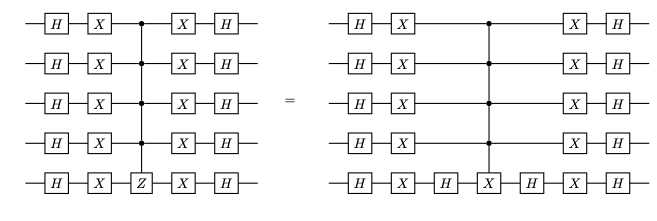

The hadamard gates will create a superposition of all states. Then, the X gate performs a qubit-flip (equivalent to the NOT classical gate) so it conducts a rotation by π radians around the x-axis of the Bloch sphere. When we have the states flipped...

In [253]:
def diffusion(q0,nqubits): 

    c.add([gates.H(i) for i in range(nqubits)])     
    c.add([gates.X(i) for i in range(nqubits)])   
    MCZ(q0,nqubits) #q0 is the target and the other ones, control qubits
    c.add([gates.X(i) for i in range(nqubits)])
    c.add([gates.H(i) for i in range(nqubits)])
    
    return c

## Main code: Grover's algorithm for quantum pattern matching

The purpose of the program is to find the location (index) of the pattern $ |p\rangle = |10\rangle$ within the string $|w\rangle = |11100000\rangle$. In this section we will apply Grover's algorithm for $n qubits$ = 6 and show that the frequency to find the pattern at the index where the match occurs is the highest among all the possibilities. 
Moreover, we will plot an histogram showing the frequencies of states, using $nshots = 2000$ after applying Grover's algorithm 3 times. 

The code follows the next procedure to find the state: 
    
1. Asks which string do you want to use (for this code you have to input $|w\rangle = |11100000\rangle$).
2. Creates the initial entangled state: 
<br>

<center> $\psi =\frac{1}{2\sqrt{2}}(|0,1\rangle +|1,2\rangle +|2,3\rangle +|3,4\rangle +|4,5\rangle +|5,6\rangle +|6,7\rangle +|7,0\rangle ) $ </center>,

<br>

which represents all the possibilities where we can find our pattern within the string. For example, $|3,4\rangle$ means that the first character of the pattern is located at the third index and as a consequence, the second character is located at the fourth index. 

To create this initial state we will proceed as follows: 
- Firstly, initiates the circuit using the double of the qubits that are needed to write the larger index where we can find the state ($3 \cdot 2 = 6$ in our case).
-  Applies hadamards to the first set of qubits (3 qubits) in order to have a superposition of all the index: $|0\rangle...|i\rangle$. This state will result in: 

<br>

<center> $\psi =\frac{1}{2\sqrt{2}}(|000\rangle +|001\rangle +|010\rangle +|011\rangle +|100\rangle +|101\rangle +|110\rangle +|111\rangle ) \otimes |000\rangle$ </center>,

<br>

- Entangles the the first set of qubits with the other one using CNOT gates to obtain the state: $\psi =\frac{1}{\sqrt{N}}\sum_{i = 1}^7 (|i\rangle \otimes |i\rangle ) $

- Increments the index of the second set of qubits by 1 using MCX gates. 

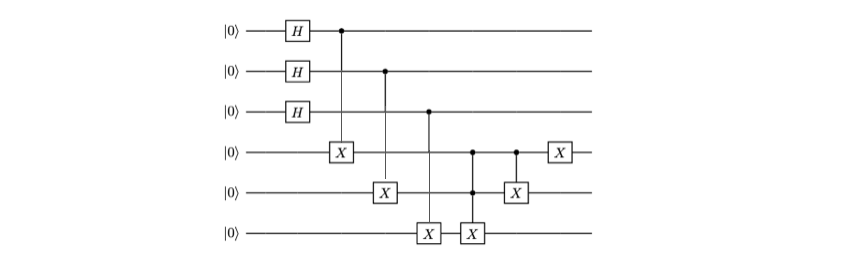

3. Starts a loop running the whole Grover's algorithm (amplitude flip and amplification) 3 times to achieve maximum probability. 
4. Executes the circuit in order to find the result 
5. Measures the state of the first three qubits which will correspond to the index of the string where the pattern can be found. 
6. Prints a dictionary with the frequencies that each index has been measured. 

In [310]:
# EL PAPER POSA AL REVES ELS QUBITS!!!!!!!

string_w = int(input("Which is string where the pattern needs to be found? "))

w = bin_to_dec(str(string_w)) 
binary_w = bin_list(w,len(str(string_w)))

index_list = [ ]
nqubits = 6

for i in range(len(binary_w)): 

    if i == (len(binary_w)-1):
        index_list.append(list(format(i,'0{}b'.format(int(nqubits/2))) + format(0,'0{}b'.format(int(nqubits/2)))))
    else: 
        index_list.append(list(format(i,'0{}b'.format(int(nqubits/2))) + format(i+1,'0{}b'.format(int(nqubits/2)))))



c = Circuit(nqubits) #index inicialization 
probs = [ ]

# entaglement 
for i in range(int(nqubits/2)):
    c.add(gates.H(i))
    
for i in range(int(nqubits/2)):
    c.add(gates.CNOT(i,i+int(nqubits/2)))

for i in range(int(nqubits/2)): 
    if i == (int(nqubits/2)-1):
        c.add(gates.X(nqubits - 1))
    else:
        c.add(gates.X(int(nqubits/2) + i).controlled_by(*range(int(nqubits/2) + i + 1, nqubits)))

for n in range(3):
    oracle_1(binary_w, nqubits, index_list)
    oracle_0(binary_w, nqubits, index_list)
    diffusion(0,nqubits)
    
c.add(gates.M(0,1,2,register_name="A"))
result = c(nshots=2000)
y = result.frequencies(binary=True, registers=True)
print(y)

Which is string where the pattern needs to be found? 11100000
{'A': Counter({'010': 580, '101': 221, '100': 207, '011': 205, '111': 205, '001': 197, '110': 195, '000': 190})}


### Plot

This plot shows, from all states available (created by 3 qubits), that the one that has been found with more frequency corresponds to the one we were searching for. We can see that the state with highest frequency is $|2\rangle$ meaning that the pattern $|p\rangle$ is located at index 2 of the string $|w\rangle$.

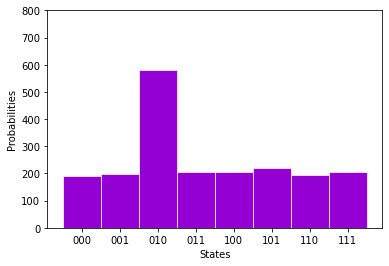

In [311]:
# FINDING STATE 
x = list(y['A'])

prob = [y['A'][el] for el in x] # elevating coeficients = probability 
fig, ax = plt.subplots()

ax.bar(x, prob, width=1, edgecolor="white",color = "darkviolet", linewidth=0.7)
ax.set(ylim=(0, 800), xlabel = 'States', ylabel = 'Probabilities')

plt.show()